In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
# loading data
df = pd.read_csv('complaints.csv')

/var/folders/c3/508pf1ws6h1bdvylp4ymd7nh0000gn/T/ipykernel_1083/4259712340.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('complaints.csv')


In [3]:
df.shape

(3493011, 18)

In [4]:
df.head(3).T

,0,1,2
Date received,2023-03-27,2023-03-27,2023-03-27
Product,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o..."
Sub-product,Credit reporting,Credit reporting,Credit reporting
Issue,Improper use of your report,Incorrect information on your report,Incorrect information on your report
Sub-issue,Reporting company used your report improperly,Information belongs to someone else,Information belongs to someone else
Consumer complaint narrative,NaN,NaN,NaN
Company public response,NaN,NaN,NaN
Company,"EQUIFAX, INC.","EQUIFAX, INC.","EQUIFAX, INC."
State,TX,CA,TX
ZIP code,77494.0,90026.0,76018.0


In [5]:
# Feature Scaling
# Working with onlyy two columns
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint'] 

print(df1.shape)

df1.head(2).T

(1259812, 2)


,5,12
Product,"Credit reporting, credit repair services, or o...",Debt collection
Consumer_complaint,N Accordance with the Fair Credit Reporting Ac...,This company keep reporting inaccurate to my X...


In [6]:
pd.DataFrame(df1.Product.unique()).values #renaming class featurea
#18 categories

array([['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Debt collection'],
       ['Checking or savings account'],
       ['Mortgage'],
       ['Money transfer, virtual currency, or money service'],
       ['Student loan'],
       ['Credit card or prepaid card'],
       ['Vehicle loan or lease'],
       ['Payday loan, title loan, or personal loan'],
       ['Bank account or service'],
       ['Credit reporting'],
       ['Prepaid card'],
       ['Credit card'],
       ['Consumer Loan'],
       ['Payday loan'],
       ['Money transfers'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

In [7]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [8]:
# Renaming categories
df2.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)


In [9]:
pd.DataFrame(df2.Product.unique()) #13 classes

,0
0,"Credit reporting, repair, or other"
1,Credit card or prepaid card
2,Checking or savings account
3,Debt collection
4,Consumer Loan
5,Bank account or service
6,Mortgage
7,Student loan
8,"Money transfer, virtual currency, or money ser..."
9,Vehicle loan or lease


In [10]:
# we will map each of these categories to a number, so that our model can understand it in a better way and 
# we will save this in a new column named ‘category_id’.

# Create a new column 'category_id' with encoded categories 
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
927076,"Credit reporting, repair, or other",Collection account from XXXXXXXX XXXX XXXX sho...,0
2038898,"Credit reporting, repair, or other",According to the Fair Credit Reporting Act ( F...,0
329660,Credit card or prepaid card,I opened an account with the 7-11 Netspend rel...,1
3426715,"Credit reporting, repair, or other",I wrote TransUnion on XX/XX/2021. I sent my di...,0
2510066,Checking or savings account,My name is XXXX XXXX and I wish to file a comp...,2


Text(0.5, 0, 'Number of ocurrences')

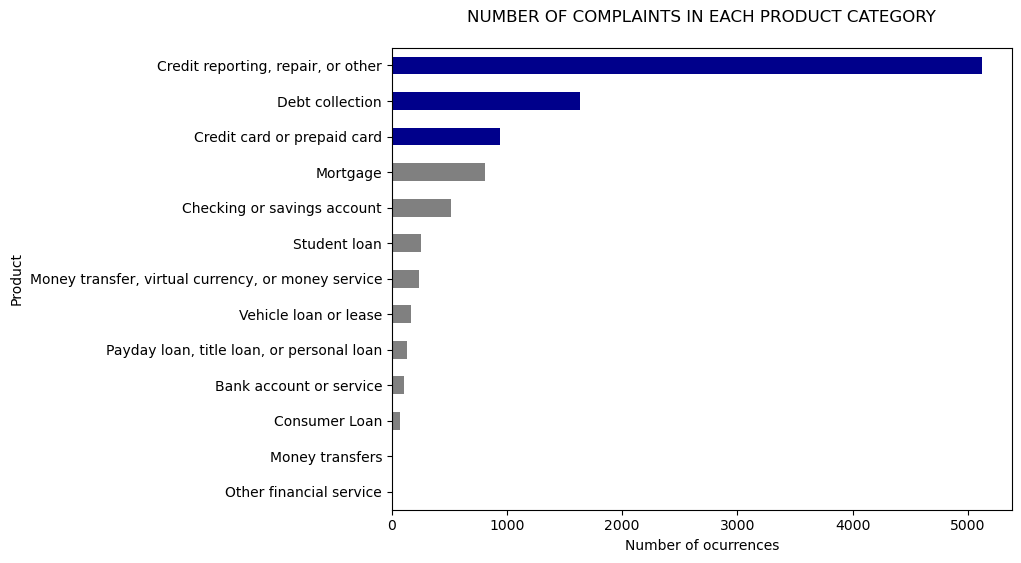

In [11]:
# visualize the data, and see how many numbers of complaints are there per category.

fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10)

### Text Processing

In [12]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 26554 features (TF-IDF score of unigrams and bigrams)


In [13]:
# Finding the three most correlated terms with each of the product categories
N = 3  # which means it will display the 3 most correlated terms
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))
     

/Users/kritipaul/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Bank account or service:
  * Most Correlated Unigrams are: ira, cd, overdraft
  * Most Correlated Bigrams are: xxxx checks, pending transaction, positive balance


/Users/kritipaul/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Checking or savings account:
  * Most Correlated Unigrams are: funds, overdraft, deposit
  * Most Correlated Bigrams are: debit card, savings account, checking account


/Users/kritipaul/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Consumer Loan:
  * Most Correlated Unigrams are: conns, santander, main
  * Most Correlated Bigrams are: error payment, requested cease, calling work


/Users/kritipaul/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Credit card or prepaid card:
  * Most Correlated Unigrams are: synchrony, merchant, card
  * Most Correlated Bigrams are: card company, american express, credit card


/Users/kritipaul/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: 1681, reporting, section
  * Most Correlated Bigrams are: credit report, 15 1681, 1681 section


/Users/kritipaul/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: debt collector, collection agency, collect debt


/Users/kritipaul/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Money transfer, virtual currency, or money service:
  * Most Correlated Unigrams are: venmo, paypal, coinbase
  * Most Correlated Bigrams are: paypal closed, cash app, paypal account


/Users/kritipaul/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Money transfers:
  * Most Correlated Unigrams are: wire, western, google
  * Most Correlated Bigrams are: western union, cancel transaction, 00 wire


/Users/kritipaul/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Mortgage:
  * Most Correlated Unigrams are: escrow, modification, mortgage
  * Most Correlated Bigrams are: escrow account, mortgage company, loan modification


/Users/kritipaul/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Other financial service:
  * Most Correlated Unigrams are: harder, upfront, endorsement
  * Most Correlated Bigrams are: xxxx settlement, know questions, point just


/Users/kritipaul/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Payday loan, title loan, or personal loan:
  * Most Correlated Unigrams are: payback, loan, payday
  * Most Correlated Bigrams are: applied personal, payday loan, main financial


/Users/kritipaul/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Student loan:
  * Most Correlated Unigrams are: loans, student, navient
  * Most Correlated Bigrams are: income based, student loans, student loan

==> Vehicle loan or lease:
  * Most Correlated Unigrams are: repossession, car, vehicle
  * Most Correlated Bigrams are: xxxx ally, vehicle xx, end lease


/Users/kritipaul/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [15]:
# Multiclassification methods

models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/Users/kritipaul/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kritipaul/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [16]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc
     

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.8239,0.006841
LogisticRegression,0.8001,0.003782
MultinomialNB,0.6797,0.007799
RandomForestClassifier,0.5129,0.000418


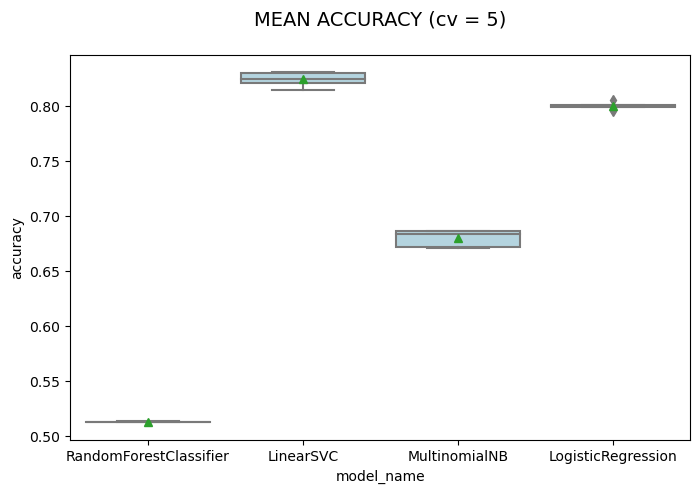

In [17]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);
     

In [18]:
#‘Linear Support Vector Machine’ outperforms all the other classification algorithms. 
#So we use LSVM

X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [19]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, labels=np.unique(y_test)))

# precision = true positives / (true positives + false positives)

# Recall = TP / (TP + FN)
# Recall is also known as sensitivity or true positive rate (TPR). A high recall means that the model is good at 
# finding all the positive samples, even if it means classifying some negative samples as positive (which could lower precision). 
# A low recall means that the model is missing some positive samples.

# F1 score is the harmonic mean of precision and recall. It is a single metric that combines both precision and 
# recall into a single value that represents the overall performance of a classification model.
# F1 score is calculated as follows:
# F1 score = 2 * (precision * recall) / (precision + recall)
# The F1 score ranges from 0 to 1, where a score of 1 represents perfect precision and recall, 
# and a score of 0 represents poor precision and recall. A high F1 score indicates that the model has a
# good balance between precision and recall, and is able to classify the positive and negative samples accurately.

# Support refers to samples in each class of the true target labels (y_test) that are used to calculate the classification 
# metrics such as precision, recall, and F1-score.

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1299
           1       0.72      0.71      0.71       215
           2       0.66      0.85      0.74       130
           3       0.76      0.72      0.74       403
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00        18
           6       0.87      0.89      0.88       202
           7       0.84      0.71      0.77        76
           8       0.79      0.60      0.68        63
           9       0.61      0.46      0.52        37
          10       0.67      0.06      0.10        36
          11       0.00      0.00      0.00         3

    accuracy                           0.82      2500
   macro avg       0.57      0.49      0.50      2500
weighted avg       0.81      0.82      0.81      2500



/Users/kritipaul/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kritipaul/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kritipaul/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'CONFUSION MATRIX - LinearSVC\n')

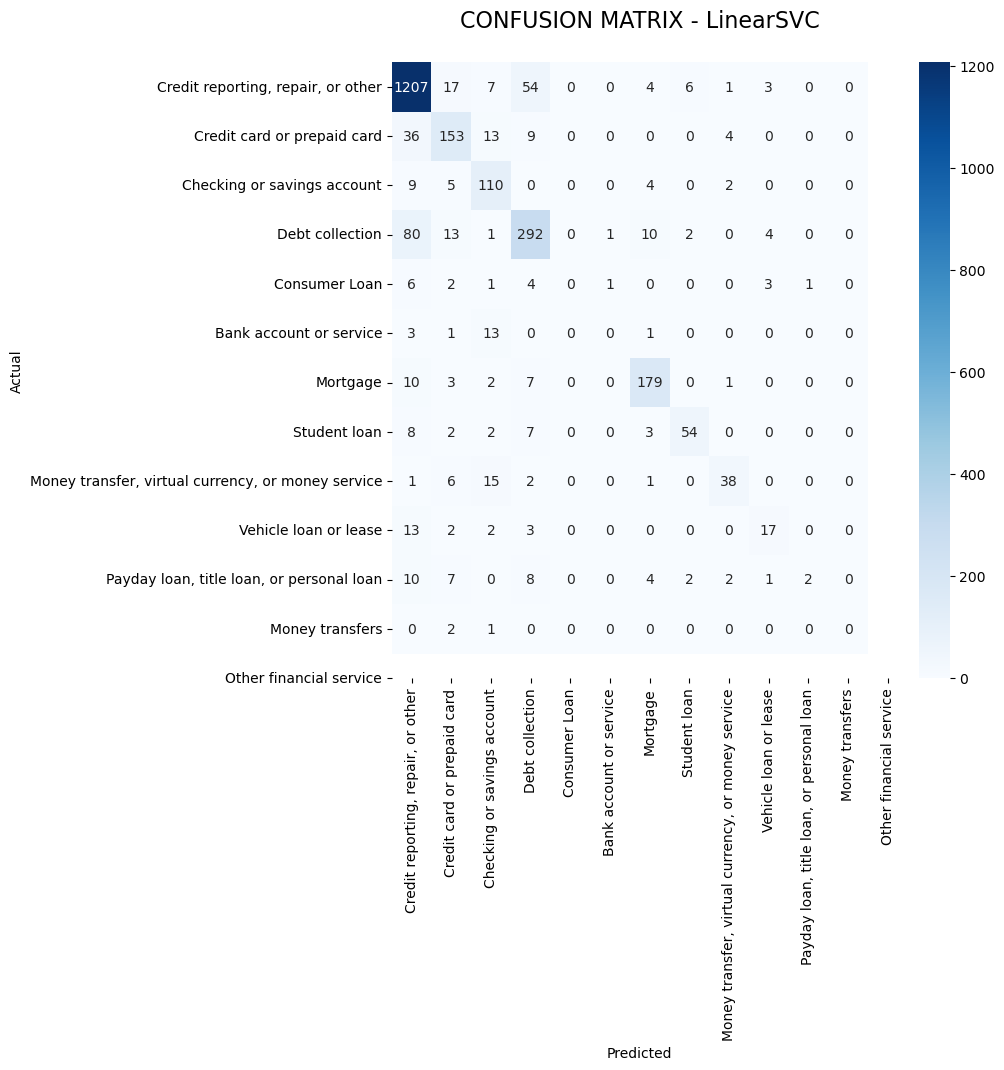

In [20]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16)
#The diagonal elements of the matrix represent the number of correct
# predictions for each class, while the off-diagonal elements represent the misclassifications.     

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)
     

In [22]:
complaint = """I have received over 27 emails from XXXX XXXX who is a representative from Midland Funding LLC. 
From XX/XX/XXXX I received approximately 6 emails. From XX/XX/XXXX I received approximately 6 emails. 
From XX/XX/XXXX I received approximately 9 emails. From XX/XX/XXXX I received approximately 6 emails. 
All emails came from the same individual, XXXX XXXX. It is becoming a nonstop issue of harassment."""

print(model.predict(fitted_vectorizer.transform([complaint])))
     

['Debt collection']


In [23]:
complaint = """Respected Sir/ Madam, I am exploring the possibilities for financing my daughter 's 
XXXX education with private loan from bank. I am in the XXXX on XXXX visa. 
My daughter is on XXXX dependent visa. As a result, she is considered as international student. 
I am waiting in the Green Card ( Permanent Residency ) line for last several years. 

I checked with Discover, XXXX XXXX websites. While they allow international students to apply for loan, they need 
cosigners who are either US citizens or Permanent Residents. I feel that this is unfair. 
I had been given mortgage and car loans in the past which I closed successfully. I have good financial history. 
I think I should be allowed to remain cosigner on the student loan. I would be much obliged if you could look into it. 
Thanking you in advance. Best Regards"""

print(model.predict(fitted_vectorizer.transform([complaint])))

['Student loan']


In [24]:
complaint = """They make me look like if I was behind on my Mortgage on the month of XX/XX/2018 & XX/XX/XXXX 
when I was not and never was, when I was even giving extra money to the Principal. 
The Money Source Web site and the managers started a problem, when my wife was trying to increase the payment, 
so more money went to the Principal and two payments came out that month and because 
I reverse one of them thru my Bank as Fraud they took revenge and committed slander against me by reporting me late at the Credit Bureaus, 
for 45 and 60 days, when it was not thru. Told them to correct that and the accounting department or the company revert 
that letter from going to the Credit Bureaus to correct their injustice. The manager by the name XXXX requested this for 
the second time and nothing yet. I am a Senior of XXXX years old and a Retired XXXX Veteran and is a disgraced that Americans 
treat us that way and do not want to admit their injustice and lies to the Credit Bureau."""
print(model.predict(fitted_vectorizer.transform([complaint])))

['Credit reporting, repair, or other']


In [41]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Generate predictions and calculate the probabilities for the testing set
y_prob = model.predict_proba(X_test)[:, 1]

/Users/kritipaul/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/Users/kritipaul/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


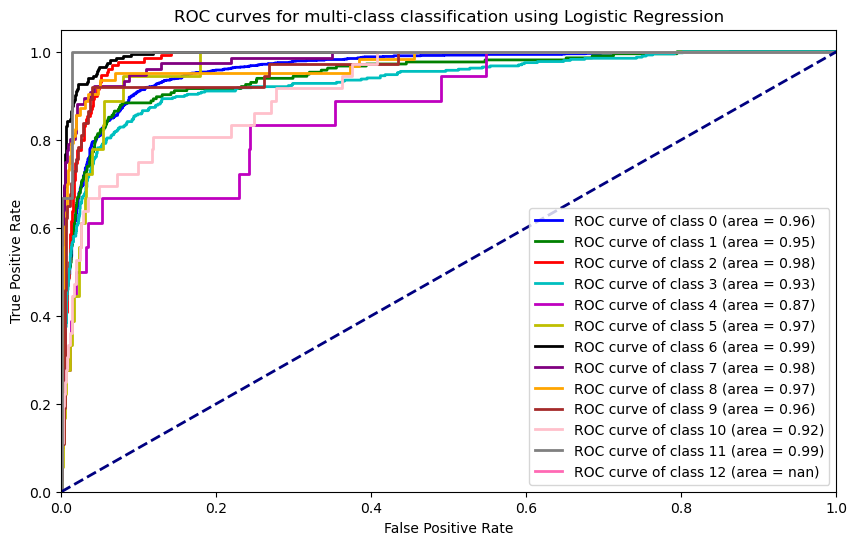

In [42]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression


probas = model.predict_proba(X_test)

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(model.classes_)
for i in range(n_classes):
    # Treat the current class as positive, and the rest as negative
    y_binary = (y_test == model.classes_[i])
    fpr[i], tpr[i], _ = roc_curve(y_binary, probas[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange', 'brown', 'pink', 'gray','hotpink' ]
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(model.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multi-class classification using Logistic Regression')
plt.legend(loc="lower right")
plt.show()